# Backward induction from terminal value function

In [58]:
import numpy as np
import scipy.optimize as opt
from scipy.interpolate import RectBivariateSpline
from numba import jit
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import time
import copy

start = time.time()

In [59]:
# Define parameters
beta = 0.95 # Discount rate
r = 0.05 # Return on A
a = 1 # Productivity in production of K
delta = 0.05 # Depreciation rate of K
alpha = 0.5 # Weight on leisure
gamma = 1 # Weight on bequest
sigma = 0.5 # Unused
params = (beta, r, a, delta, alpha, gamma, sigma)

In [60]:
# Define g(x) and g'(x) (labor market equilibrium tradeoff) function
@jit
def g(x):
    k = 5/4
    s = 1/2
    a = 1/(k**0.5 - s)
    y = k - (x/a + s)**2
    
    return y

@jit
def g_prime(x):
    k = 5/4
    s = 1/2
    a = 1/(k**0.5 - s)
    y = (-2*(x/a + s))/a
    
    return y

# Terminal period

In [61]:
# Define terminal utility
@jit
def utility_T(values, state, params):
    beta, r, a, delta, alpha, gamma, sigma = params # Unpack parameters
    A0, K0 = state # Unpack chosen state
    c, l = values # Unpack values to evaluate at
    
    # Put constraints into utility function
    A1 = (1+r)*A0 + (1-l)*K0 - c
    
    # Evaluate utility
    u = - np.log(c) - alpha*np.log(l) - gamma*np.log(A1)
    return u

In [62]:
# Grid parameters; time dependent
T = 7
A_min = np.zeros(T)
A_max = np.zeros(T)
A_size = 100 # Number of grid points in every time period
K_min = np.ones(T)
K_max = np.zeros(T)
K_size = 100 # Number of grid points in every time period

A_grid = np.zeros((A_size, T))
K_grid = np.zeros((K_size, T))

# Set up state grids
for t in range(T):
    A_max[t] = 2**t
    K_max[t] = 2*(2**t)
    
    K_min[t] = (1-delta)**t
    
    A_grid[:, t] = np.linspace(A_min[t], A_max[t], A_size)
    K_grid[:, t] = np.linspace(K_min[t], K_max[t], K_size)

T_grid = np.linspace(0, T, T+1, dtype = int)

# Value grid
V_grid = np.ones((A_size, K_size, T))

# Policy grid
c_policy = np.ones((A_size, K_size, T))
l_policy = np.ones((A_size, K_size, T))
x_policy = np.zeros((A_size, K_size, T))

# Store interpolated value function in dict
V_dict = {}

In [63]:
# Compute value function and policy at t = T
for a, A in np.ndenumerate(A_grid[:, T-1]):
    for k, K in np.ndenumerate(K_grid[:, T-1]):
        
        a_ind = a[0]
        k_ind = k[0]
        
        # Compute value function at terminal state
        state = (A, K)
        results = opt.minimize(utility_T, [0.1, 0.1], bounds = ((0, None), (0, 1)), args = (state, params,), method = 'SLSQP')
        
        # Store policy results and value function
        V_grid[a_ind, k_ind, T-1] = -results.fun
        c_policy[a_ind, k_ind, T-1] = results.x[0]
        l_policy[a_ind, k_ind, T-1] = results.x[1]

In [64]:
# Interpolate terminal value function and store in dict
V_dict[T-1] = RectBivariateSpline(A_grid[:, T-1], K_grid[:, T-1], V_grid[:, :, T-1])

In [65]:
K, A = np.meshgrid(K_grid[:, T-1], A_grid[:, T-1])

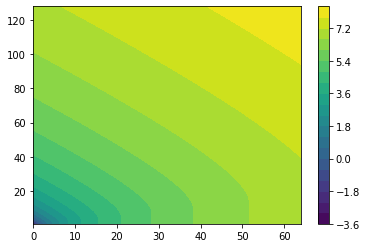

In [66]:
plt.contourf(A, K, V_grid[:, :, -1], 20, cmap='viridis')
plt.colorbar();

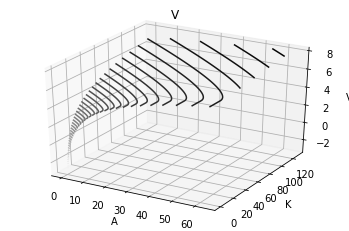

In [67]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(A, K, V_grid[:, :, -1], 50, cmap='binary')
ax.set_title('V')
ax.set_xlabel('A')
ax.set_ylabel('K')
ax.set_zlabel('V');

Text(0.5, 0, 'V')

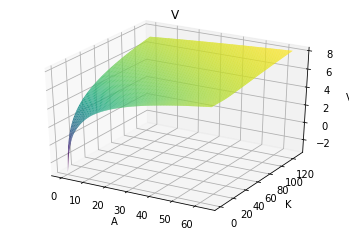

In [68]:
ax = plt.axes(projection='3d')
ax.plot_surface(A, K, V_grid[:, :, -1], rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.set_title('V')
ax.set_xlabel('A')
ax.set_ylabel('K')
ax.set_zlabel('V')

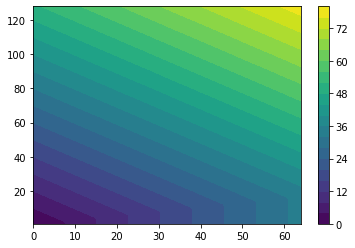

In [69]:
plt.contourf(A, K, c_policy[:, :, -1], 20, cmap='viridis')
plt.colorbar();

Text(0.5, 0, 'V')

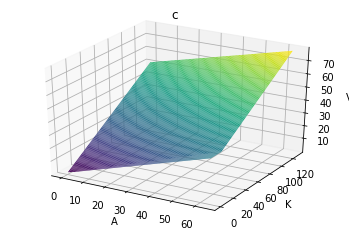

In [70]:
ax = plt.axes(projection='3d')
ax.plot_surface(A, K, c_policy[:, :, -1], rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.set_title('c')
ax.set_xlabel('A')
ax.set_ylabel('K')
ax.set_zlabel('V')

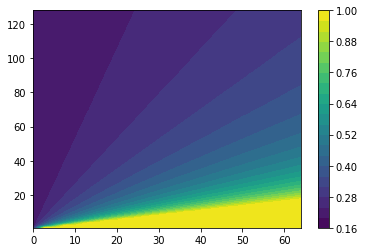

In [71]:
plt.contourf(A, K, l_policy[:, :, -1], 20, cmap='viridis')
plt.colorbar();

In [72]:
c_policy[:, 0, -1]

array([ 0.29414213,  0.56510393,  0.83685265,  1.10838714,  1.38090284,
        1.69695818,  2.036017  ,  2.37575408,  2.71509925,  3.05418091,
        3.39236881,  3.7333273 ,  4.0726919 ,  4.41197682,  4.75105492,
        5.08825728,  5.43029593,  5.76966541,  6.1089793 ,  6.44816969,
        6.78710681,  7.12560316,  7.46339188,  7.80605728,  8.1454426 ,
        8.48481691,  8.82417527,  9.16350061,  9.50276477,  9.84193965,
       10.18098502, 10.51982448, 10.8584048 , 11.19661856, 11.53436889,
       11.87152356, 12.21817045, 12.55755515, 12.89693956, 13.23631597,
       13.57567921, 13.91502009, 14.25435137, 14.59363807, 14.9328891 ,
       15.27209094, 15.61122139, 15.95025147, 16.28918199, 16.62796191,
       16.96659043, 17.30500328, 17.64320099, 17.98111207, 18.31869153,
       18.65592516, 18.99271213, 19.34544635, 19.68482926, 20.02420495,
       20.36359347, 20.70297165, 21.04234675, 21.38170905, 21.72106425,
       22.0604107 , 22.39974111, 22.73906694, 23.07835516, 23.41

In [73]:
# Inspect bequest
V_test = np.zeros((A_size, K_size))
bequest = np.zeros((A_size, K_size))

for a, A in np.ndenumerate(A_grid[:, T-1]):
    for k, K in np.ndenumerate(K_grid[:, T-1]):
        
        a_ind = a[0]
        k_ind = k[0]
        
        state = (A, K)
        c = c_policy[a_ind, k_ind, T-1]
        l = l_policy[a_ind, k_ind, T-1]
        values = (c, l)
        
        V_test[a_ind, k_ind] = -utility_T(values, state, params)
        bequest[a_ind, k_ind] = (1+r)*A + (1-l)*K - c

Text(0.5, 0, 'V')

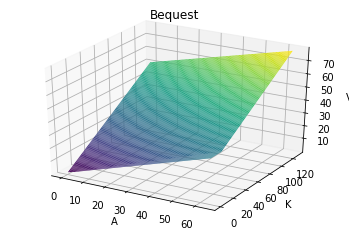

In [74]:
K, A = np.meshgrid(K_grid[:, T-1], A_grid[:, T-1])
ax = plt.axes(projection='3d')
ax.plot_surface(A, K, bequest[:, :], rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.set_title('Bequest')
ax.set_xlabel('A')
ax.set_ylabel('K')
ax.set_zlabel('V')

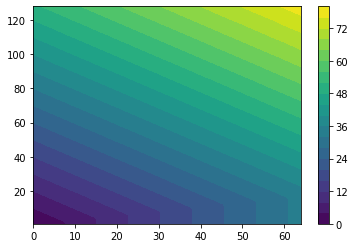

In [75]:
plt.contourf(A, K, bequest[:, :], 20, cmap='viridis')
plt.colorbar();

# Iterate back

In [76]:
# Define objective function for t < T
def objective(values, state, V_T_interpolate, params):
    beta, r, a, delta, alpha, gamma, sigma = params # Unpack parameters
    A0, K0 = state # Unpack current state
    c, l, x = values # Unpack values to evaluate at
    
    # State evolution
    A1 = (1+r)*A0 + g(x)*(1-l)*K0 - c
    K1 = (1 + a*x*(1-l) - delta)*K0
    
    # Value next period
    V1 = RectBivariateSpline.__call__(V_T_interpolate, A1, K1)[0][0] # Continuation value of A1, K1
    
    # Evaluate objective
    u = - np.log(c) - alpha*np.log(l) - beta*V1
    return u

In [77]:
# Define borrowing constraint function
def no_borrowing_constraint(values, state, params):
    beta, r, a, delta, alpha, gamma, sigma = params # Unpack parameters
    A0, K0 = state # Unpack current state
    c, l, x = values # Unpack values to evaluate at
    
    # Asset next period has to be weakly positive
    A1 = (1+r)*A0 + g(x)*(1-l)*K0 - c
    
    return A1

In [78]:
# Compute value function and policy at t
for t in range(T-2, -1, -1):
    print(t)
    for a, A in np.ndenumerate(A_grid[:, t]):
        for k, K in np.ndenumerate(K_grid[:, t]):
            
            a_ind = a[0]
            k_ind = k[0]

            state = (A, K)
            
            # Define constraints, including no borrowing constraints
            constraint_list = [{'type':'ineq',
                    'fun':no_borrowing_constraint,
                    'args':(state, params,)},
                   {'type':'ineq',
                    'fun': lambda x: x[0]},
                   {'type':'ineq',
                    'fun': lambda x: x[1]},
                   {'type':'ineq',
                    'fun': lambda x: 1 - x[1]},
                   {'type':'ineq',
                    'fun': lambda x: x[2]},
                   {'type':'ineq',
                    'fun': lambda x: 1 - x[2]}]

            # Compute value function at t
            results = opt.minimize(objective, [0.1, 0.1, 0.1], constraints = constraint_list, args = (state, V_dict[t+1], params,), method = 'SLSQP')

            # Store results
            V_grid[a_ind, k_ind, t] = -results.fun
            c_policy[a_ind, k_ind, t] = results.x[0]
            l_policy[a_ind, k_ind, t] = results.x[1]
            x_policy[a_ind, k_ind, t] = results.x[2]
            
            # Interpolate value function at t and store in dict
            V_dict[t] = RectBivariateSpline(A_grid[:, t], K_grid[:, t], V_grid[:, :, t])

5


C:\Users\churn\Utilities\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in log
  from ipykernel import kernelapp as app
C:\Users\churn\Utilities\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log
  from ipykernel import kernelapp as app


4
3
2
1
0


Text(0.5, 0, 'c')

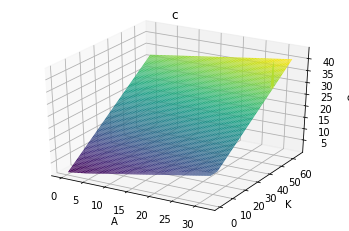

In [115]:
# Check results
t = T-2
K, A = np.meshgrid(K_grid[:, t], A_grid[:, t])

ax = plt.axes(projection='3d')
ax.plot_surface(A, K, c_policy[:, :, t], rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.set_title('c')
ax.set_xlabel('A')
ax.set_ylabel('K')
ax.set_zlabel('c')

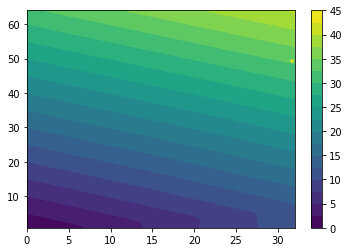

In [116]:
plt.contourf(A, K, c_policy[:, :, t], 20, cmap='viridis')
plt.colorbar();

Text(0.5, 0, 'c')

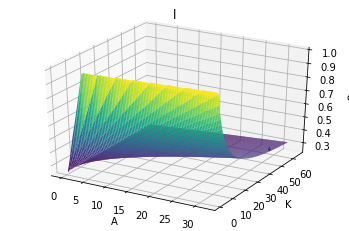

In [117]:
ax = plt.axes(projection='3d')
ax.plot_surface(A, K, l_policy[:, :, t], rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.set_title('l')
ax.set_xlabel('A')
ax.set_ylabel('K')
ax.set_zlabel('c')

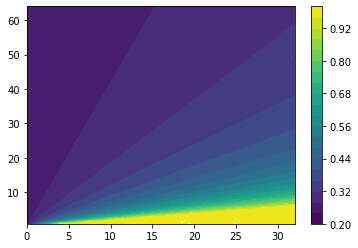

In [118]:
plt.contourf(A, K, l_policy[:, :, t], 20, cmap='viridis')
plt.colorbar();

Text(0.5, 0, 'c')

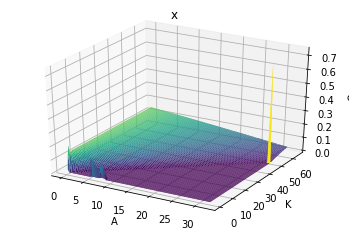

In [119]:
ax = plt.axes(projection='3d')
ax.plot_surface(A, K, x_policy[:, :, t], rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.set_title('x')
ax.set_xlabel('A')
ax.set_ylabel('K')
ax.set_zlabel('c')

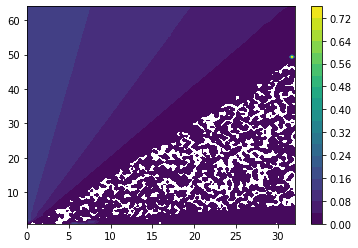

In [120]:
plt.contourf(A, K, x_policy[:, :, t], 20, cmap='viridis')
plt.colorbar();

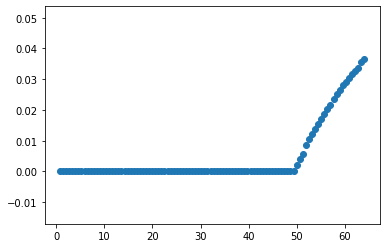

In [121]:
plt.scatter(K_grid[:, t], x_policy[99, :, t])

Text(0.5, 0, 'V')

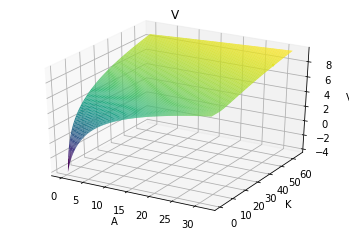

In [122]:
ax = plt.axes(projection='3d')
ax.plot_surface(A, K, V_grid[:, :, t], rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.set_title('V')
ax.set_xlabel('A')
ax.set_ylabel('K')
ax.set_zlabel('V')

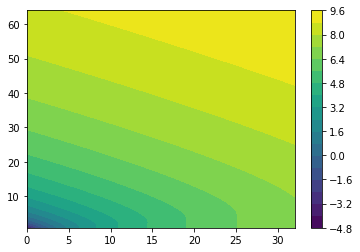

In [123]:
plt.contourf(A, K, V_grid[:, :, t], 20, cmap='viridis')
plt.colorbar();

In [124]:
end = time.time()

In [125]:
runtime = end-start

In [126]:
runtime

1107.5778489112854